# C. Evaluations Dashboard
This evaluates the following:
- Game projections
- DFS player projections
- DFS lineups 

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"


baseball_path = r'C:\Users\james\Documents\MLB\Database'

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### C01. Scores

In [3]:
%run "C:\Users\james\Documents\MLB\Code\C01. Gambling.ipynb"

##### Read in game results

In [4]:
all_games_df = read_and_save_games(team_map, generate=False)

##### Read in simulation scores

In [5]:
%%time
start_date = "20220407"
end_date = "20220507"

sim_score_df = read_sim_scores(start_date, end_date)

CPU times: total: 15.3 s
Wall time: 1min 44s


In [6]:
date_list = list(sim_score_df['date'].unique())

##### Read in Odds

In [7]:
%%time
df = pd.merge(sim_score_df, all_games_df, on='game_id', how='left', suffixes=("", "_act"))

gambling_files = []
for date in date_list:
    odds_df = read_odds(date)
    date_df = pd.merge(df, odds_df, on=['date', 'game_num', 'VisitorTeamShort'], how='inner')
    date_df = gambling_stats_games(date_df)
    date_df['date'] = date
    gambling_files.append(date_df)
    
    
gambling_df = pd.concat(gambling_files, axis=0).reset_index(drop=True)
gambling_df = vegas_runs(gambling_df)
gambling_df.reset_index(inplace=True, drop=True)

CPU times: total: 2 s
Wall time: 2.41 s


In [8]:
print("Over/Under\n", gambling_df.query(f'date <= "{end_date}"')['OverUnderPick'].value_counts())

Over/Under
 Under      199
Over       135
Neither     93
Name: OverUnderPick, dtype: int64


In [9]:
len(gambling_df)

427

In [10]:
# Function to determine SpreadSide
def determine_spread_side(row):
    if (row['SpreadPick'] == 'Away' and row['Spread'] < 0) or (row['SpreadPick'] == 'Home' and row['Spread'] > 0):
        return 'Underdog'
    elif (row['SpreadPick'] == 'Away' and row['Spread'] > 0) or (row['SpreadPick'] == 'Home' and row['Spread'] < 0):
        return 'Favorite'
    else:
        return 'Neither'

# Apply the function to create the SpreadSide column
gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)

print(gambling_df['SpreadSide'].value_counts())

Underdog    239
Neither     121
Favorite     67
Name: SpreadSide, dtype: int64


##### Vegas Runs

In [11]:
gambling_df.query(f'date <= "{end_date}"')[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act', 'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].describe()

,VisitorModelRuns,HomeModelRuns,VisitorVegasRuns,HomeVegasRuns,away_score_act,home_score_act,VisitorModelSqError,HomeModelSqError,VisitorVegasSqError,HomeVegasSqError
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,4.219335,4.290476,4.014988,4.344965,3.964871,4.081967,8.865440,9.142115,8.901124,8.909813
std,0.600381,0.569445,0.689431,0.666567,2.988426,3.056637,14.015754,19.538507,14.644680,17.952646
min,2.806250,2.768750,2.500000,2.600000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000
25%,3.809375,3.927083,3.500000,3.900000,2.000000,2.000000,1.237656,1.291625,1.105000,1.210000
50%,4.145833,4.293750,3.900000,4.300000,4.000000,3.000000,4.595664,3.867778,4.410000,4.000000
75%,4.541667,4.658333,4.400000,4.800000,6.000000,6.000000,11.362535,10.515158,10.240000,10.565000
max,6.435417,5.956250,7.000000,6.200000,17.000000,21.000000,163.893338,264.062500,156.250000,222.010000


##### Graph Payouts

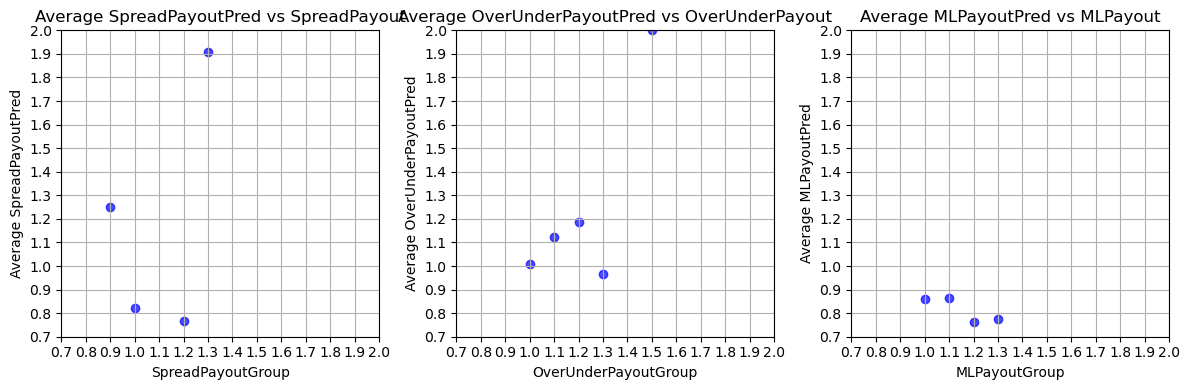

		Spread: 0.7941660811016475			OverUnder: 1.0559719257532014			Money Line: 0.8521503498237208


In [20]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'Spread', ax=axes[0])
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'OverUnder', ax=axes[1])
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = gambling_df.query(f'date <= "{end_date}"')['SpreadPayout'].mean()
OverUnderMean = gambling_df.query(f'date <= "{end_date}"')['OverUnderPayout'].mean()
MLMean = gambling_df.query(f'date <= "{end_date}"')['MLPayout'].mean()
print(f"\t\tSpread: {SpreadMean}\t\t\tOverUnder: {OverUnderMean}\t\t\tMoney Line: {MLMean}")

In [13]:
significance_test(gambling_df.query(f'(date <= "{end_date}") and ((SpreadPick == "Away" and Spread > 0) or (SpreadPick == "Home" and Spread < 0))'), "Spread", 1, 0.05)
significance_test(gambling_df.query(f'(date <= "{end_date}") and (OverUnderPick == "Under")'), "OverUnder", 1.0, 0.05)
significance_test(gambling_df.query(f'(date <= "{end_date}")'), "ML", 1.4, 0.05)

Average: 1.4516, n: 67, p_value: 0.003, significant: Yes
Average: 1.13147, n: 199, p_value: 0.047, significant: Yes
Average: 0.98333, n: 3, p_value: 0.988, significant: No


In [14]:
gambling_df.query('SpreadPick == "Home" and Spread > 0')['SpreadPayout'].mean()
# gambling_df['SpreadPayout'].mean()

0.6203078243633895

In [15]:
gambling_df['ModelDiff'] = (gambling_df['VisitorModelRuns'] - gambling_df['HomeModelRuns']).abs()
gambling_df['VegasDiff'] = (gambling_df['VisitorVegasRuns'] - gambling_df['HomeVegasRuns']).abs()
gambling_df.describe()

,game_id,game_num,VisitorModelRuns,HomeModelRuns,away_id,home_id,game_num_act,away_score_act,home_score_act,venue_id,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,AwaySpreadPred,HomeSpreadPred,UnderPred,OverPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,UnderAct,OverAct,AwayMLAct,HomeMLAct,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,ModelDiff,VegasDiff
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,308.000000,334.000000,323.000000,308.000000,334.000000,323.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,662290.248244,1.023419,4.219335,4.290476,128.482436,128.779859,1.049180,3.964871,4.081967,1543.922717,-0.223653,8.168618,1.919994,2.032716,1.914201,1.914201,2.143605,1.859021,4.014988,4.344965,8.509812,0.465266,0.496946,0.037788,8.046838,0.428571,0.536300,0.035129,0.517535,0.481304,0.001161,0.533958,0.466042,0.000000,0.471897,0.528103,0.480094,0.519906,0.963380,0.946430,0.988555,0.929041,0.985800,0.961584,0.949452,1.084304,1.062603,0.854961,0.973635,0.922512,0.794166,1.055972,0.852150,1.066661,1.092443,1.089513,0.254464,0.050117,8.865440,8.901124,0.208509,0.262998,9.142115,8.909813,8.359953,0.611617,0.812881
std,687.207323,0.151408,0.600381,0.569445,14.235331,14.351662,0.216498,2.988426,3.056637,1703.206009,1.475855,0.979076,0.332914,0.353429,0.050600,0.050600,0.439764,0.345248,0.689431,0.666567,0.894110,0.072751,0.071615,0.048780,4.236291,0.495452,0.499266,0.184321,0.110544,0.110395,0.012084,0.499431,0.499431,0.000000,0.075373,0.075373,0.500190,0.500190,0.109249,0.112204,0.128527,0.136629,0.123096,0.105614,1.017966,1.072709,0.936975,0.935729,1.052950,0.915533,0.992479,0.941114,1.107658,0.060117,0.076877,0.083704,2.970075,2.986553,14.015754,14.644680,3.019933,2.976810,19.538507,17.952646,1.005040,0.447366,0.525319
min,661032.000000,1.000000,2.806250,2.768750,108.000000,108.000000,1.000000,0.000000,0.000000,1.000000,-1.500000,6.500000,1.476190,1.454545,1.800000,1.800000,1.400000,1.266667,2.500000,2.600000,6.366667,0.195833,0.295833,0.000000,1.000000,0.000000,0.000000,0.000000,0.264583,0.235417,0.000000,0.000000,0.000000,0.000000,0.270833,0.335417,0.000000,0.000000,0.635000,0.540909,0.662996,0.483333,0.657672,0.647429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000548,1.000500,-12.802083,-12.500000,0.000000,0.000000,-16.250000,-14.900000,0.000017,0.000000,6.600000,0.002083,0.000000
25%,661736.000000,1.000000,3.809375,3.927083,115.000000,115.000000,1.000000,2.000000,2.000000,12.000000,-1.500000,7.500000,1.636943,1.716855,1.877193,1.877193,1.775194,1.604235,3.500000,3.900000,7.907292,0.418750,0.450000,0.000000,5.000000,0.000000,0.000000,0.000000,0.419792,0.387500,0.000000,0.000000,0.000000,0.000000,0.416667,0.475000,0.000000,0.000000,0.893217,0.869646,0.902437,0.836380,0.902854,0.890260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.021516,1.031194,1.029505,-1.493750,-1.650000,1.237656,1.105000,-1.361458,-1

In [16]:
# You're almost impossibly bad at spreads lol
# Might be good to know why
# Very good when predicting unders (Biased toward over)
# I think you're probably always taking the points in the Spreads
# Theory: You're always predicting close games. Because of this, your spread pick is always the points. 


##### Graph Runs

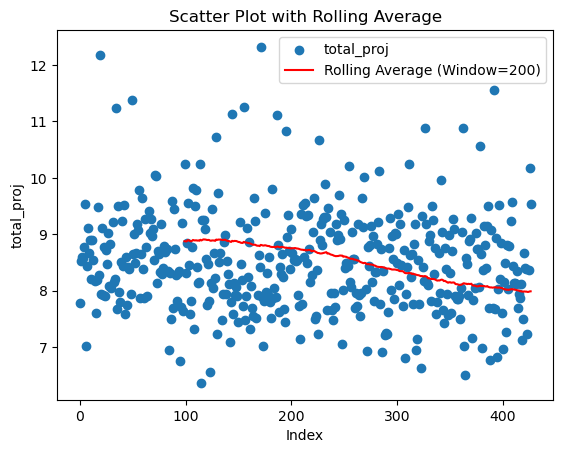

In [17]:
# Total: Choose Vegas or Actual to compare my runs to 
total = "TotalVegasRuns"

# You can convert the index to a list for the x-axis and get the values for the y-axis
x_values = gambling_df.index.tolist()
y_values = gambling_df['total_proj'].tolist()

# Calculate the rolling average
rolling_avg = gambling_df[f'{total}'].rolling(window=200, min_periods=100).mean()

# Create a scatter plot
plt.scatter(x_values, y_values, label='total_proj')

# Add the rolling average line
plt.plot(x_values, rolling_avg, color='red', label='Rolling Average (Window=200)')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('total_proj')
plt.title('Scatter Plot with Rolling Average')
plt.legend()

# Show the plot
plt.show()

In [18]:
afadsfaf

NameError: name 'afadsfaf' is not defined

### C02. Projections

In [ ]:
%run "C:\Users\james\Documents\MLB\Code\C02. Projections.ipynb"

In [ ]:
# Read in contest history
history = pd.read_csv(os.path.join(baseball_path, "Utilities", "draftkings-contest-entry-history.csv"))

In [ ]:
# Read in cleaned contest history (this needs to be fixed long-term)
contests = pd.read_csv(os.path.join(baseball_path, "Utilities", "Contests.csv"))
contests = contests[::-1]

In [ ]:
contests = contests[~contests['draftGroupId'].isna()].reset_index(drop=True)

In [ ]:
comparable_dfs = []
for i in range(len(contests)):
    try:
        contestKey = contests['contestKey'][i].astype('int')
        draftGroupId = contests['draftGroupId'][i].astype('int')

        # print(draftGroupId)

        # Read in projection dataframes
        my_df = read_player_sims(draftGroupId)
        # print(my_df.head(10))
        dff_df = read_dff(contestKey, history)
        roto_df = read_roto(contestKey, history)

        # Merge them together
        projection_df = merge_projections(my_df, dff_df, roto_df, quietly=True)

        # Read in contest results
        score_df = read_results(contestKey)

        # Evaluate projections
        complete_df = evaluate_projections_post(projection_df, score_df)
        comparable_df = compare_projections(complete_df)
        
        # print("Me: ", len(my_df['TeamAbbrev'].unique()), "DFF: ", len(dff_df['TeamAbbrev'].unique()), "Roto: ", len(roto_df['TeamAbbrev'].unique()), "Merged:", len(comparable_df['TeamAbbrev'].unique()))
        # print("Me: ", len(my_df), "DFF: ", len(dff_df), "Roto:", len(roto_df), "Merged:", len(comparable_df))
        
        # Add to list of dataframes
        comparable_dfs.append(comparable_df)
        
    except:
        pass

In [ ]:
all_projections = pd.concat(comparable_dfs, axis=0).head(360000)
len(all_projections)

In [ ]:
batter_means = all_projections.query('`Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means = all_projections.query('`Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means = all_projections.query('Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')


batter_means_unimp = all_projections.query('imp == 0 and `Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means_unimp = all_projections.query('imp == 0 and `Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means_unimp = all_projections.query('imp == 0 and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')

batter_means_imp = all_projections.query('imp == 1 and `Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means_imp = all_projections.query('imp == 1 and `Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means_imp = all_projections.query('imp == 1 and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')



means_df = pd.concat([batter_means, pitcher_means, all_means, batter_means_unimp, pitcher_means_unimp, all_means_unimp, batter_means_imp, pitcher_means_imp, all_means_imp], axis=1).T
means_df.set_index(pd.Index(["Batters", "Pitchers", "All", "Batters Unimp", "Pitchers Unimp", "All Unimp", "Batters Imp", "Pitchers Imp", "All Imp"]), inplace=True)

means_df.drop(columns={'ownership'})